# Introdction to cuML 

cuML is suite of GPU-accelerated machine learning algorithms, designed to accelerate your data science and analytical workloads. From pre-processing data through to training and evaluating models, cuML proivdes a user-friendly API and a wide range of functionality to help you get the most from your GPUs.  

### Key Concepts

The following key concepts sit at the core of cuML's design, and enable you to get the most out of your data:

#### 1. Where possible, match the scikit-learn API

cuML estimators look and feel just like scikit-learn estimators. You initialize them with key parameters, fit them with a fit method, then call predict or transform for inference.

#### 2. Accept flexible input types, return predictable output types

cuML estimators can accept NumPy arrays, cuDF dataframes, cuPy arrays, 2d PyTorch tensors, and really any kind of standards-based Python array input you can throw at them.

By default, outputs will mirror the data type you provided.

#### 3. Be fast!

On a modern GPU, these can exceed the performance of CPU-based equivalents by a factor of anything from 4x (for a medium-sized linear regression) to over 1000x (for large-scale tSNE dimensionality reduction). In many cases, performance advantages appear as the dataset grows.

In this notebook we step through some of the functionality of cuML, in the context of a standard data science workflow. 

We begin importing the cuML module, as well as cuDF, and simulating some data to use in the rest of the notebook.

In [1]:
import cudf
import cuml

In the next cell we simulate 100,000 data samples. Each sample has 70 features, and belongs to one of two distinct classes. 

In [2]:
from cuml.datasets import make_classification, make_regression

NFEATURES = 70

X, y = make_classification(
    n_samples=100000,
    n_features=NFEATURES,
    n_informative=NFEATURES,
    n_redundant=0,
    n_classes=2,
    class_sep=0.01,
    random_state=12
)


Let's take a look at one  sample, below: 

In [3]:
print(X[0], y[0])

[ -1.9980202    3.9556055   -2.6809473   -2.8941283    0.9291506
   3.065332     0.6860125    5.5918903   -4.6641183   -3.4821155
   3.257878    -4.8201156    1.6298611  -15.224871     0.38845295
  -0.02067883  -0.543524    -0.05218849   0.29240498   0.4383254
   8.921663     1.4747543    3.1600246    5.535305     0.82545483
   3.1657386    2.759442     5.6177692    2.6039474    3.0497644
   0.63242275  -3.1524584    3.0872924    1.1401846   -3.3063142
  -4.09136      7.074211     1.2850634   -3.8583715    0.55310374
  -1.4354117    1.3183861   -2.924463    -2.1001132    4.5445905
   1.1647617   -1.0559907   -6.4415402    6.506664    -2.323572
   6.187154     3.5928614    9.423635     1.7855508    0.34430474
   6.3704047    6.2556496   -0.26052332   5.361425    -3.538777
   2.1183784   -6.2708344    4.6758003   -3.738656    -1.0349029
   2.316828    -5.930797     0.15795861  -8.333983     2.1715055 ] 0


## Split data into training and testing set

We use the `train_test_split` function to divide our data into training and testing sets. 

We'll use the testing set later to evaluate the performance of the models we train. 

In [4]:
from cuml.model_selection import train_test_split

## set train_size such that 70% of data is in the training set, 30% in the test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=101)

In [5]:
print(len(X_train))
print(len(X_test))

70000
30000


## Explore and preprocess the data

Now that we have split our data into training and test sets we can begin to apply transformations. Just like scikit-learn, cuML estimators admit the _initialise_, _fit_, and _predict_ or _transform_ functionality. 

Let's see this in action with a the `MaxAbsScaler`. This scaler transforms each feature (column) of our data set by scaling it so that the maximum absolute value of each feature is 1.  

In [6]:
from cuml.preprocessing import MaxAbsScaler

In [7]:
## initialise the estimator
ma_scaler = MaxAbsScaler()

# fit the scaler to our training data
ma_scaler.fit(X_train)


# transform the testing data: 
ma_scaler.transform(X_test)

array([[ 0.08541051,  0.04574193, -0.25868776, ...,  0.04394882,
        -0.00525169, -0.32427284],
       [ 0.2839447 ,  0.37636262, -0.3690871 , ...,  0.00267437,
        -0.09742295,  0.2868341 ],
       [ 0.16277884,  0.22848997,  0.00721657, ...,  0.0916765 ,
         0.02357151,  0.09881533],
       ...,
       [-0.14040077,  0.17064498,  0.14495125, ..., -0.01784683,
         0.2011555 ,  0.0394319 ],
       [ 0.2973317 , -0.14708188,  0.34465507, ..., -0.15666665,
        -0.32545227,  0.1068793 ],
       [ 0.01214891,  0.15419926, -0.3105086 , ...,  0.11526794,
         0.35807538, -0.126101  ]], dtype=float32)

Similarly, we can use a `RobustScaler` to transform the data so that each feature is on a similar scale. 

This Scaler removes the median and scales the data according to the interquantile range.

In [8]:
from cuml.preprocessing import RobustScaler

# initialise the estimator
rs = RobustScaler()

# fit the estimator to the training data
rs.fit(X_train)

# transform testing data
rs.transform(X_test)

array([[ 0.27718088,  0.13896777, -0.8418211 , ...,  0.1616044 ,
        -0.01769234, -1.0306079 ],
       [ 0.90910655,  1.1693693 , -1.2018533 , ...,  0.00913524,
        -0.32055292,  0.9218878 ],
       [ 0.52344096,  0.7085143 ,  0.02534103, ...,  0.337912  ,
         0.07701626,  0.32116508],
       ...,
       [-0.44156653,  0.5282365 ,  0.47451875, ..., -0.06667074,
         0.6605299 ,  0.13143413],
       [ 0.95171684, -0.46198058,  1.125789  , ..., -0.57947564,
        -1.0698221 ,  0.34692958],
       [ 0.04399244,  0.4769823 , -1.0108182 , ...,  0.4250595 ,
         1.1761445 , -0.39744592]], dtype=float32)

And we can inspect properties of the Scaler, such as the scale factor: 

In [9]:
rs.scale_

array([6.35032785, 6.44095349, 6.79551202, 6.32966983, 6.53788012,
       6.64531672, 6.45503956, 6.32018942, 6.40238178, 6.76403505,
       6.22050089, 6.50096053, 6.55863214, 6.43624294, 6.53785229,
       6.36557275, 6.46495354, 6.28573775, 6.17296183, 6.31272662,
       6.22233289, 6.63490158, 6.43231112, 6.26866263, 6.20223182,
       6.39026451, 6.42943138, 6.43496788, 6.34803963, 6.71131968,
       6.67621696, 6.54794925, 6.57270426, 6.2324779 , 6.43320483,
       6.3657831 , 6.53314948, 6.35471964, 6.61971724, 6.25920451,
       6.63549674, 6.57850635, 6.50974876, 6.42993313, 6.31201524,
       6.67033678, 6.52674371, 6.4192611 , 6.33742702, 6.241144  ,
       6.44758427, 6.75257468, 6.42581367, 6.44181091, 6.56425184,
       6.47299588, 6.66851884, 6.74984872, 6.74974865, 6.51129937,
       6.33052784, 6.34172666, 6.54697716, 6.18710494, 6.75972241,
       6.51529789, 6.45811135, 6.52624094, 6.45145816, 6.38879675])

## Dimensionality Reduction

When exploring our data, we often want to project the features down to 2-dimensions so that we can plot and visualise the data set, and see if we can identify patterns. 

We begin by using Principle Component Analysis (PCA), a linear dimensionality reduction technique. PCA requires input data to be on the same scale, so we first transform our data using the RobustScaler.

In [10]:
from cuml import PCA

In [11]:
%%time
# initialise the estimator
pca = PCA(n_components = 2)

# fit the estimater to our training data
pca.fit(rs.transform(X_train))

## transform our testing data
pca_test = pca.transform(rs.transform(X_test))

CPU times: user 116 ms, sys: 60.1 ms, total: 176 ms
Wall time: 3.78 s


We can examine the proportion of variance explained by the PCA and inspect the components:

In [12]:
print(f'Components: {pca.components_}')
print(f'Explained variance: {pca.explained_variance_}')
exp_var = pca.explained_variance_ratio_
print(f'Explained variance ratio: {exp_var}')

Components: [[-0.05909706  0.01801155  0.0741434  -0.0680749   0.03234185  0.01911815
  -0.32202154  0.03990031  0.10352241 -0.09809297  0.02929723  0.05729806
  -0.16865826 -0.11624307 -0.12834518  0.03468076  0.16475973 -0.01919991
   0.28346533  0.13221711 -0.06726342  0.03772593  0.05597396  0.06672216
   0.11632077  0.10623258  0.11975448  0.13803078  0.02399221  0.11451922
  -0.07122128  0.1590112   0.23601267  0.2073007   0.10733192  0.05279021
   0.11074218  0.00545435  0.02777288 -0.01152427 -0.21798125  0.09582856
  -0.02994056 -0.04662078  0.09114991 -0.01287654  0.14655872 -0.02079763
   0.0152019  -0.11429025  0.14535442 -0.09559696  0.09526934 -0.16426626
  -0.06811177  0.12478419 -0.04641464 -0.06593445 -0.04003704 -0.03518747
  -0.17666101 -0.223866    0.31917208 -0.04565047  0.09308991  0.15789504
   0.05159391 -0.06492973 -0.03131886 -0.04307794]
 [-0.03008626  0.09077378 -0.03259045 -0.01614369  0.11988664  0.0102212
  -0.04683876  0.08303002  0.03236256 -0.04268901 

PCA is fast, but there are more sophisticated techniques we can use to possibly expose more structure in the data. Due to the non-linearity of these alternative dimensionality reduction techniques, they are more computationaly expensive. However, we benefit here from the acceleration provided by NVIDIA GPUs and the RAPIDS implementations. 

UMAP is a non-linear dimensionality reduction technique:

In [13]:
from cuml import UMAP

In [14]:
%%time
umap = UMAP(n_components = 2)
umap.fit(X_train)
umap_test = umap.transform(X_test)

CPU times: user 1.1 s, sys: 538 ms, total: 1.63 s
Wall time: 5.1 s


As you can see, UMAP is notably slower than PCA, but let's see if it allows us to uncover more structure in our data by plotting the projected test data: 

In [15]:
import matplotlib.pyplot as plt
import cupy as cp

In [16]:
# transfering data to cpu to plot.
umap_cpu = cp.asnumpy(umap_test)
pca_cpu = cp.asnumpy(pca_test)

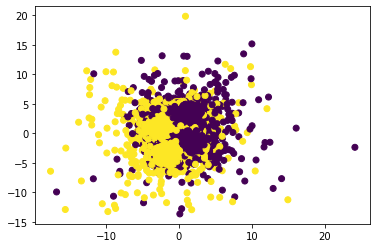

In [17]:
plt.scatter(umap_cpu[:,0], umap_cpu[:,1], c=cp.asnumpy(y_test))

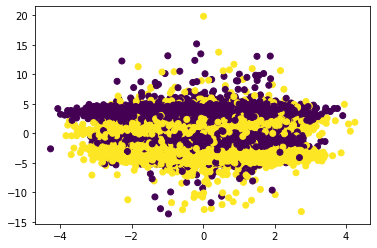

In [18]:
plt.scatter(pca_cpu[:,0], umap_cpu[:,1], c = cp.asnumpy(y_test))

### Training a  model 

Now that we've transformed our data, and have been able to identify structure in the data we can go ahead and train a model to distinguish between the two classes of data. Let's start by training a logistic regression model. 

Again, we follow the _initialise_, _fit_, _predict_ workflow that we used with the scalers and dimensionality reduction techniques earlier in the notebook. 

In [19]:
## initialise
clr = cuml.LogisticRegression()

## fit to scaled data
clr.fit(rs.transform(X_train), y_train)

## predict 
clr_preds = clr.predict(rs.transform(X_test))
clr_preds

array([1, 1, 0, ..., 0, 1, 1])

### Evaluating the model

cuML provides a range of built in metrics to evaluate model performance. 


In [20]:
cuml.metrics.accuracy.accuracy_score(y_test, clr_preds)

0.5002333521842957

It looks like this prediction accuracy is only slightly higher than 50%. We would expect similar results by just tossing a coin to allocate classes. Let's inviestigate this further by looking at a confusion matrix:

In [21]:
cuml.metrics.confusion_matrix(y_test, clr_preds)

array([[6143, 8929],
       [6064, 8864]])

The confusion matrix tells us that there are many misclassifications in both the '0' and '1' classes. Let's try to train another model and see if we can get better performance:

In [22]:
# initialise
ckn = cuml.neighbors.KNeighborsClassifier()

# fit
ckn.fit(rs.transform(X_train), y_train)

# predict
ckn_preds = ckn.predict(rs.transform(X_test))
ckn_preds

array([1, 0, 1, ..., 1, 1, 0])

In [23]:
cuml.metrics.accuracy.accuracy_score(y_test, ckn_preds)

0.9884666800498962

In [24]:
cuml.metrics.confusion_matrix(ckn_preds, y_test)

array([[14917,   191],
       [  155, 14737]])

For our dataset, the k-nearest neighbour model is much better at predicting classes than the Logistic Regression model. 

## Pipelines

To quote the wonderful scikit-learn documentation, `Pipeline` "sequentially [applies] a list of transforms and a final estimator" to a dataset.

By collecting transformations and training into a single pipeline, we can confidently do things like cross-validation and hyper-parameter optimization without worrying about data leakage.

cuML transformations and estimators are fully compatible with the scikit-learn Pipeline API.

In our previous examples we used a RobustScaler followed by a k-Nearest neighbour model. Let's put those together in a pipeline:

In [25]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', cuml.preprocessing.RobustScaler()),
    ('knn', cuml.neighbors.KNeighborsClassifier()),
])

We can fit the whole pipeline in one command, and make predictions from the raw data, without having to first call the scale, then the model.

In [26]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('knn', KNeighborsClassifier())])

In [27]:
pipe.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0])

In [28]:
cuml.metrics.confusion_matrix(pipe.predict(X_test), y_test)

array([[14917,   191],
       [  155, 14737]])

## Explainability

Model explainability is often critically important. cuML provides a GPU-accelerated SHAP Kernel Explainer and a Permutation Explainer.

In [29]:
from cuml.explainer import KernelExplainer
from cuml.datasets import make_classification, make_regression
from cuml.model_selection import train_test_split
import cuml
Xr, yr = make_regression(
    n_samples=102,
    n_features=10,
    noise=0.1,
    random_state=42)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr,
    yr,
    test_size=2,
    random_state=42)

model = cuml.svm.SVR().fit(Xr_train, yr_train)

cu_explainer = KernelExplainer(
    model=model.predict,
    data=Xr_train,
    is_gpu_model=True)

cu_shap_values = cu_explainer.shap_values(Xr_test)
cu_shap_values

array([[ 0.9414298 ,  1.2883328 ,  1.2064881 , -0.30565166,  0.35499024,
        -0.27393305,  0.09936225,  0.10741448, -0.5426788 ,  0.13819003],
       [-1.4213939 ,  0.7651012 , -1.4898689 , -0.08747172, -0.25713038,
        -0.2309308 , -0.28295338, -0.11387861, -0.08676493,  0.29971695]],
      dtype=float32)

## Pickling Models

So far, we've only stored our models in memory. This final section demonstrates basic pickling cuML models, and pipelines, for persistence. This allows us to load these models into other environments or programs and use them to make predictions on new data. 

We can pickle individual estimators.

In [30]:
import pickle

In [31]:
pickle.dump(model, open("model.pkl", "wb"))
loaded_model = pickle.load(open("model.pkl", "rb"))
loaded_model

SVR()

We can even pickle the pipeline we made earlier.

In [32]:
pickle.dump(pipe, open("pipeline.pkl", "wb"))
loaded_pipeline = pickle.load(open("pipeline.pkl", "rb"))

print(loaded_pipeline.score(X_test, y_test))
loaded_pipeline.predict(X_test)

0.9884666800498962


array([1, 0, 1, ..., 1, 1, 0])

We hope this notebook has shown you how you can use cuML to carry out your standard Machine Learning and analytics workflows on NVIDIA GPUs. 

To find out more, check out [RAPIDS.ai](http://rapids.ai) and look at the cuML [docs](https://docs.rapids.ai/api/cuml/stable/) to see the full range of the cuML functionality. 